In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p, run_pheno_correlations, get_fdr_p_df, get_sys_prop, run_ttest, get_cohend, create_dummy_vars

In [4]:
train_test_str = 'train_test'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125 250
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str, parc_str = parc_str, parc_scale = parc_scale)

In [5]:
# output file prefix
outfile_prefix = exclude_str+'_'+parc_str+'_'+str(parc_scale)+'_'
outfile_prefix

't1Exclude_schaefer_400_'

### Setup directory variables

In [6]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/3_output/figs


## Setup plots

In [7]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('pair')

phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear']
metrics = ['ct', 'vol']
metrics_label_short = ['Thickness', 'Volume']
metrics_label = ['Thickness', 'Volume']

## Load data

In [8]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True)
df_node_train = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid'], inplace = True)

# Test
df_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'test.csv'))
df_test.set_index(['bblid', 'scanid'], inplace = True)
df_node_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'resp_test.csv'))
df_node_test.set_index(['bblid', 'scanid'], inplace = True)

# concat
df = pd.concat((df_train, df_test), axis = 0); print(df.shape)
df_node = pd.concat((df_node_train, df_node_test), axis = 0); print(df_node.shape)

(1376, 49)
(1376, 800)


## Load nispat outputs

In [9]:
z_cv = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '4_run_normative', outfile_prefix+'out_cv', 'Z.txt'), delimiter = ' ').transpose()
df_z_cv = pd.DataFrame(data = z_cv, index = df_node_train.index, columns = df_node_train.columns)

z = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '4_run_normative', outfile_prefix+'out', 'Z.txt'), delimiter = ' ').transpose()
df_z_test = pd.DataFrame(data = z, index = df_node_test.index, columns = df_node_test.columns)

# concat
df_z = pd.concat((df_z_cv,df_z_test), axis = 0); print(df_z.shape)

(1376, 800)


## Setup region filter
### regions with SMSE <1 in normative model

In [10]:
smse = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '4_run_normative', outfile_prefix+'out', 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node.columns)

In [11]:
smse_thresh = 1
region_filter = df_smse.iloc[:,0] < smse_thresh

In [12]:
region_filter.sum()

750

# Group analysis

## Create grouping variable

In [13]:
groups = ('goassessSmryDep', 'goassessSmryAdd')
# groups = ('goassessSmryMood','goassessSmryPsy')
# groups = ('goassessSmryDep','goassessSmryPsy')

group_idx = create_dummy_vars(df.loc[df.loc[:,train_test_str] == 1,:], groups, filter_comorbid = True)

goassessSmryDep: 191
goassessSmryAdd: 226
Comorbid N: 47
goassessSmryDep: 144
goassessSmryAdd: 179


In [14]:
# pad with zeros to match dimensions with training set
zero_pad = np.zeros((np.sum(df[train_test_str] == 0),group_idx.shape[1])).astype(bool)
group_idx = np.append(zero_pad, group_idx, axis = 0); print(group_idx.shape)

(1376, 2)


### Demographics

In [15]:
print(groups[0],
      'mean age:', df.loc[group_idx[:,0],'ageAtScan1_Years'].mean().round(2),
      '(', df.loc[group_idx[:,0],'ageAtScan1_Years'].std().round(2), ')')

goassessSmryDep mean age: 17.62 ( 2.28 )


In [16]:
df.loc[group_idx[:,0],'sex_adj'].value_counts() / np.sum(group_idx[:,0]) * 100

1    67.361111
0    32.638889
Name: sex_adj, dtype: float64

In [17]:
print(groups[1],
      'mean age:', df.loc[group_idx[:,1],'ageAtScan1_Years'].mean().round(2),
      '(', df.loc[group_idx[:,1],'ageAtScan1_Years'].std().round(2), ')')

goassessSmryAdd mean age: 13.63 ( 3.1 )


In [18]:
df.loc[group_idx[:,1],'sex_adj'].value_counts() / np.sum(group_idx[:,1]) * 100

0    62.011173
1    37.988827
Name: sex_adj, dtype: float64

In [19]:
sp.stats.ttest_ind(df.loc[group_idx[:,0],'ageAtScan1_Years'], df.loc[group_idx[:,1],'ageAtScan1_Years'])

Ttest_indResult(statistic=12.87137744885286, pvalue=7.453251933639135e-31)

In [20]:
df_hc_cv = df.loc[df[train_test_str] == 0,:].copy()
df_hc_ho = df.loc[np.logical_and(df[train_test_str] == 1,df['squeakycleanExclude'] == 0),:].copy()
df_hc = pd.concat((df_hc_cv,df_hc_ho), axis = 0)
# df_hc = df.loc[df[train_test_str] == 0,:].copy()
df_hc.loc[:,'group'] = 0
print(df_hc.shape)

df_dep = df.loc[group_idx[:,0],:].copy()
df_dep.loc[:,'group'] = 1
print(df_dep.shape)

df_add = df.loc[group_idx[:,1],:].copy()
df_add.loc[:,'group'] = 2
print(df_add.shape)

df_tmp = pd.concat((df_hc, df_dep, df_add), axis = 0)

df_z_tmp = df_z.loc[df_tmp.index,:].copy()

(408, 50)
(144, 50)
(179, 50)


### Regress age/sex out of node features

In [21]:
# # Given differences in demographics between groups, we regress age/sex from z scores before calculating cohen's D
# # df_nuis = df_tmp.loc[:,['ageAtScan1_Years','sex_adj']]
# df_nuis = df_tmp.loc[:,'mprage_antsCT_vol_TBV']
# df_nuis = sm.add_constant(df_nuis)

# # df_z
# cols = df_z_tmp.columns
# mdl = sm.OLS(df_z_tmp.loc[:,cols], df_nuis).fit()
# y_pred = mdl.predict(df_nuis)
# y_pred.columns = cols
# df_z_tmp = df_z_tmp.loc[:,cols] - y_pred

# # phenos
# mdl = sm.OLS(df_tmp.loc[:,phenos], df_nuis).fit()
# y_pred = mdl.predict(df_nuis)
# y_pred.columns = phenos
# df_tmp.loc[:,phenos] = df_tmp.loc[:,phenos] - y_pred

## Disorder groups vs. CV HCs

In [22]:
for metric in metrics:
    df_y = df_z_tmp.loc[df_tmp.loc[:,'group'] == 0,:].filter(regex = metric, axis = 1)
    
    df_x = df_z_tmp.loc[df_tmp.loc[:,'group'] == 1,:].filter(regex = metric, axis = 1)
    df_out = run_ttest(df_x, df_y, tail = 'one')
    print('Depression', metric + ', significant t-tests:', (np.sum(df_out.loc[:,'p-corr'] < .05) / df_out.shape[0] * 100))
    
    df_x = df_z_tmp.loc[df_tmp.loc[:,'group'] == 2,:].filter(regex = metric, axis = 1)
    df_out = run_ttest(df_x, df_y, tail = 'one')
    print('ADHD', metric + ', significant t-tests:', (np.sum(df_out.loc[:,'p-corr'] < .05) / df_out.shape[0] * 100))

Depression ct, significant t-tests: 2.25
ADHD ct, significant t-tests: 0.25
Depression vol, significant t-tests: 37.5
ADHD vol, significant t-tests: 0.5


In [23]:
metric = metrics[1]; print(metric)

vol


### Spatial correlations

In [24]:
df_y = df_z_tmp.loc[df_tmp.loc[:,'group'] == 0,:].filter(regex = metric, axis = 1)

X = get_cohend(df_z_tmp.loc[df_tmp.loc[:,'group'] == 1,:].filter(regex = metric, axis = 1), df_y).loc[:,'d'].rename('Depression')
y = get_cohend(df_z_tmp.loc[df_tmp.loc[:,'group'] == 2,:].filter(regex = metric, axis = 1), df_y).loc[:,'d'].rename('ADHD')
df_input = pd.concat((X, y), axis = 1)

df_input.head()

,Depression,ADHD
vol_0,-0.114236,-0.099313
vol_1,-0.256815,-0.163493
vol_2,-0.215870,-0.024991
vol_3,-0.164705,-0.189552
vol_4,-0.156803,-0.155439


[0.19 0.  ]


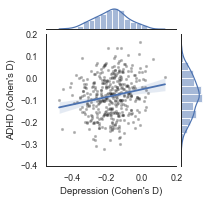

In [25]:
print(np.round(sp.stats.pearsonr(x = df_input.loc[:,'Depression'], y = df_input.loc[:,'ADHD']),2))

sns.set(style='white', context = 'paper', font_scale = 1)
f = sns.jointplot(x = df_input.loc[:,'Depression'], y = df_input.loc[:,'ADHD'], kind="reg")
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
f.set_axis_labels('Depression (Cohen\'s D)', 'ADHD (Cohen\'s D)')
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_ylim([-0.4, 0.2])
f.ax_joint.set_xlim([-0.55, 0.2])
f.savefig(outfile_prefix+'cohensd_spatial_corr_depression->adhd.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

### Regress p out of node features

In [26]:
r = np.zeros(len(phenos))

for p, pheno in enumerate(phenos):
#     df_nuis = df_tmp.loc[:,['ageAtScan1_Years','sex_adj',pheno]]
#     df_nuis = df_tmp.loc[:,['mprage_antsCT_vol_TBV',pheno]]
    df_nuis = df_tmp.loc[:,pheno]
    df_nuis = sm.add_constant(df_nuis)

    cols = df_z_tmp.columns
    mdl = sm.OLS(df_z_tmp.loc[:,cols], df_nuis).fit()
    y_pred = mdl.predict(df_nuis)
    y_pred.columns = cols
    df_z_tmp_regr = df_z_tmp.loc[:,cols] - y_pred

    df_y = df_z_tmp_regr.loc[df_tmp.loc[:,'group'] == 0,:].filter(regex = metric, axis = 1)

    X = get_cohend(df_z_tmp_regr.loc[df_tmp.loc[:,'group'] == 1,:].filter(regex = metric, axis = 1), df_y).loc[:,'d'].rename('Depression')
    y = get_cohend(df_z_tmp_regr.loc[df_tmp.loc[:,'group'] == 2,:].filter(regex = metric, axis = 1), df_y).loc[:,'d'].rename('ADHD')
    
    r[p] = sp.stats.pearsonr(X,y)[0]
    print(pheno, np.round(sp.stats.pearsonr(X,y),2))

Overall_Psychopathology [-0.06  0.25]
Psychosis_Positive [0.17 0.  ]
Psychosis_NegativeDisorg [0.17 0.  ]
AnxiousMisery [0.22 0.  ]
Externalizing [0.19 0.  ]
Fear [0.17 0.  ]


In [27]:
sp.stats.pearsonr(x = df_input.loc[:,'Depression'], y = df_input.loc[:,'ADHD'])[0] - np.mean(r[1:])

0.0029344636427271475

In [28]:
p = 0
pheno = phenos[p]; print(pheno)

Overall_Psychopathology


In [29]:
# Given differences in demographics between groups, we regress age/sex from z scores before calculating cohen's D
# df_nuis = df_tmp.loc[:,['ageAtScan1_Years','sex_adj',pheno]]
# df_nuis = df_tmp.loc[:,['mprage_antsCT_vol_TBV',pheno]]
df_nuis = df_tmp.loc[:,pheno]
df_nuis = sm.add_constant(df_nuis)

# df_z
cols = df_z_tmp.columns
mdl = sm.OLS(df_z_tmp.loc[:,cols], df_nuis).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = cols
df_z_tmp_regr = df_z_tmp.loc[:,cols] - y_pred

In [30]:
df_y = df_z_tmp_regr.loc[df_tmp.loc[:,'group'] == 0,:].filter(regex = metric, axis = 1)

X = get_cohend(df_z_tmp_regr.loc[df_tmp.loc[:,'group'] == 1,:].filter(regex = metric, axis = 1), df_y).loc[:,'d'].rename('Depression')
y = get_cohend(df_z_tmp_regr.loc[df_tmp.loc[:,'group'] == 2,:].filter(regex = metric, axis = 1), df_y).loc[:,'d'].rename('ADHD')
df_input_p = pd.concat((X, y), axis = 1)

df_input_p.head()

,Depression,ADHD
vol_0,-0.079677,-0.081098
vol_1,-0.160144,-0.110987
vol_2,-0.107435,0.031838
vol_3,-0.098037,-0.154478
vol_4,-0.046217,-0.096621


[-0.06  0.25]


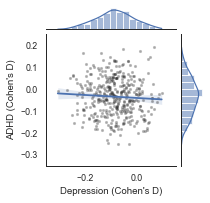

In [31]:
print(np.round(sp.stats.pearsonr(x = df_input_p.loc[:,'Depression'], y = df_input_p.loc[:,'ADHD']),2))

sns.set(style='white', context = 'paper', font_scale = 1)
f = sns.jointplot(x = df_input_p.loc[:,'Depression'], y = df_input_p.loc[:,'ADHD'], kind="reg")
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
f.set_axis_labels('Depression (Cohen\'s D)', 'ADHD (Cohen\'s D)')
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_ylim([-0.35, 0.25])
f.ax_joint.set_xlim([-0.35, 0.15])
f.savefig(outfile_prefix+'cohensd_spatial_corr_depression->adhd_p_nuis.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

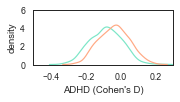

In [32]:
f, ax = plt.subplots()
f.set_figwidth(2.5)
f.set_figheight(1)
sns.kdeplot(df_input.loc[:,'ADHD'], ax = ax, color = cmap[0], label = 'no p')
sns.kdeplot(df_input_p.loc[:,'ADHD'], ax = ax, color = cmap[1], label = 'p')
ax.legend().remove()
ax.set_ylim([0, 6])
ax.set_xlim([-0.5, 0.3])
ax.set_xlabel('ADHD (Cohen\'s D)')
ax.set_ylabel('density')
f.savefig(outfile_prefix+'cohensd_adhd.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [33]:
sp.stats.ttest_rel(df_input_p.loc[:,'ADHD'],df_input.loc[:,'ADHD'])

Ttest_relResult(statistic=31.055751110277043, pvalue=1.6175876170156443e-108)

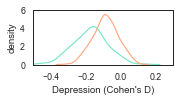

In [34]:
f, ax = plt.subplots()
f.set_figwidth(2.5)
f.set_figheight(1)
sns.kdeplot(df_input.loc[:,'Depression'], ax = ax, color = cmap[0], label = 'no p')
sns.kdeplot(df_input_p.loc[:,'Depression'], ax = ax, color = cmap[1], label = 'p')
ax.legend().remove()
ax.set_ylim([0, 6])
ax.set_xlim([-0.5, 0.3])
ax.set_xlabel('Depression (Cohen\'s D)')
ax.set_ylabel('density')
f.savefig(outfile_prefix+'cohensd_depression.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [35]:
sp.stats.ttest_rel(df_input_p.loc[:,'Depression'],df_input.loc[:,'Depression'])

Ttest_relResult(statistic=31.292384628128016, pvalue=1.8854812169127094e-109)